###  Module & Utility Imports

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.lines as mlines


### Load Evaluation Results and Model Configurations

In [2]:
# Define input directory and model configurations
input_dir = './EvalResults/SummaryTables/'

# Main model configurations for comparison
main_models = [
    'SKZFC_ART_1_30_800_Mimic',
    'SKZFC_ART_1_30_800_VitalDB',
    'SKZFC_II_1_30_800_Mimic',
    'SKZFC_II_1_30_800_VitalDB'
]

# Best performing model configurations
best_models = [
    'SKZFC_ART_1_50_800_Mimic',
    'SKZFC_ART_1_50_800_VitalDB',
    'SKZFC_II_1_50_800_Mimic',
    'SKZFC_II_1_50_800_VitalDB'
]


# Load evaluation results
AblCompTabs = pd.read_csv(os.path.join(input_dir, 'AblCompTabs.csv'))
BenchCompTabs_NOMS = pd.read_csv(os.path.join(input_dir, 'BenchCompTabs_NOMS.csv'))
BenchCompTabs = pd.read_csv(os.path.join(input_dir, 'BenchCompTabs.csv'))
AggSensitivityDetail = pd.read_csv(os.path.join(input_dir, 'AggSensitivityDetail.csv'))
SensitivityDetailTabs = pd.read_csv(os.path.join(input_dir, 'SensitivityDetailTabs.csv'))
SenseAccMItable = pd.read_csv(os.path.join(input_dir, 'SenseAccMItable.csv'))
# Filter sensitivity analysis excluding best models
SenseModels = SenseAccMItable[~SenseAccMItable['Model'].isin(best_models)].reset_index(drop=True)

### Benchmark Comparison and Performance Analysis

[Saved] ./PaperWork/Figures\Benchmark_comparison_and_Metric_Wise_performance.png


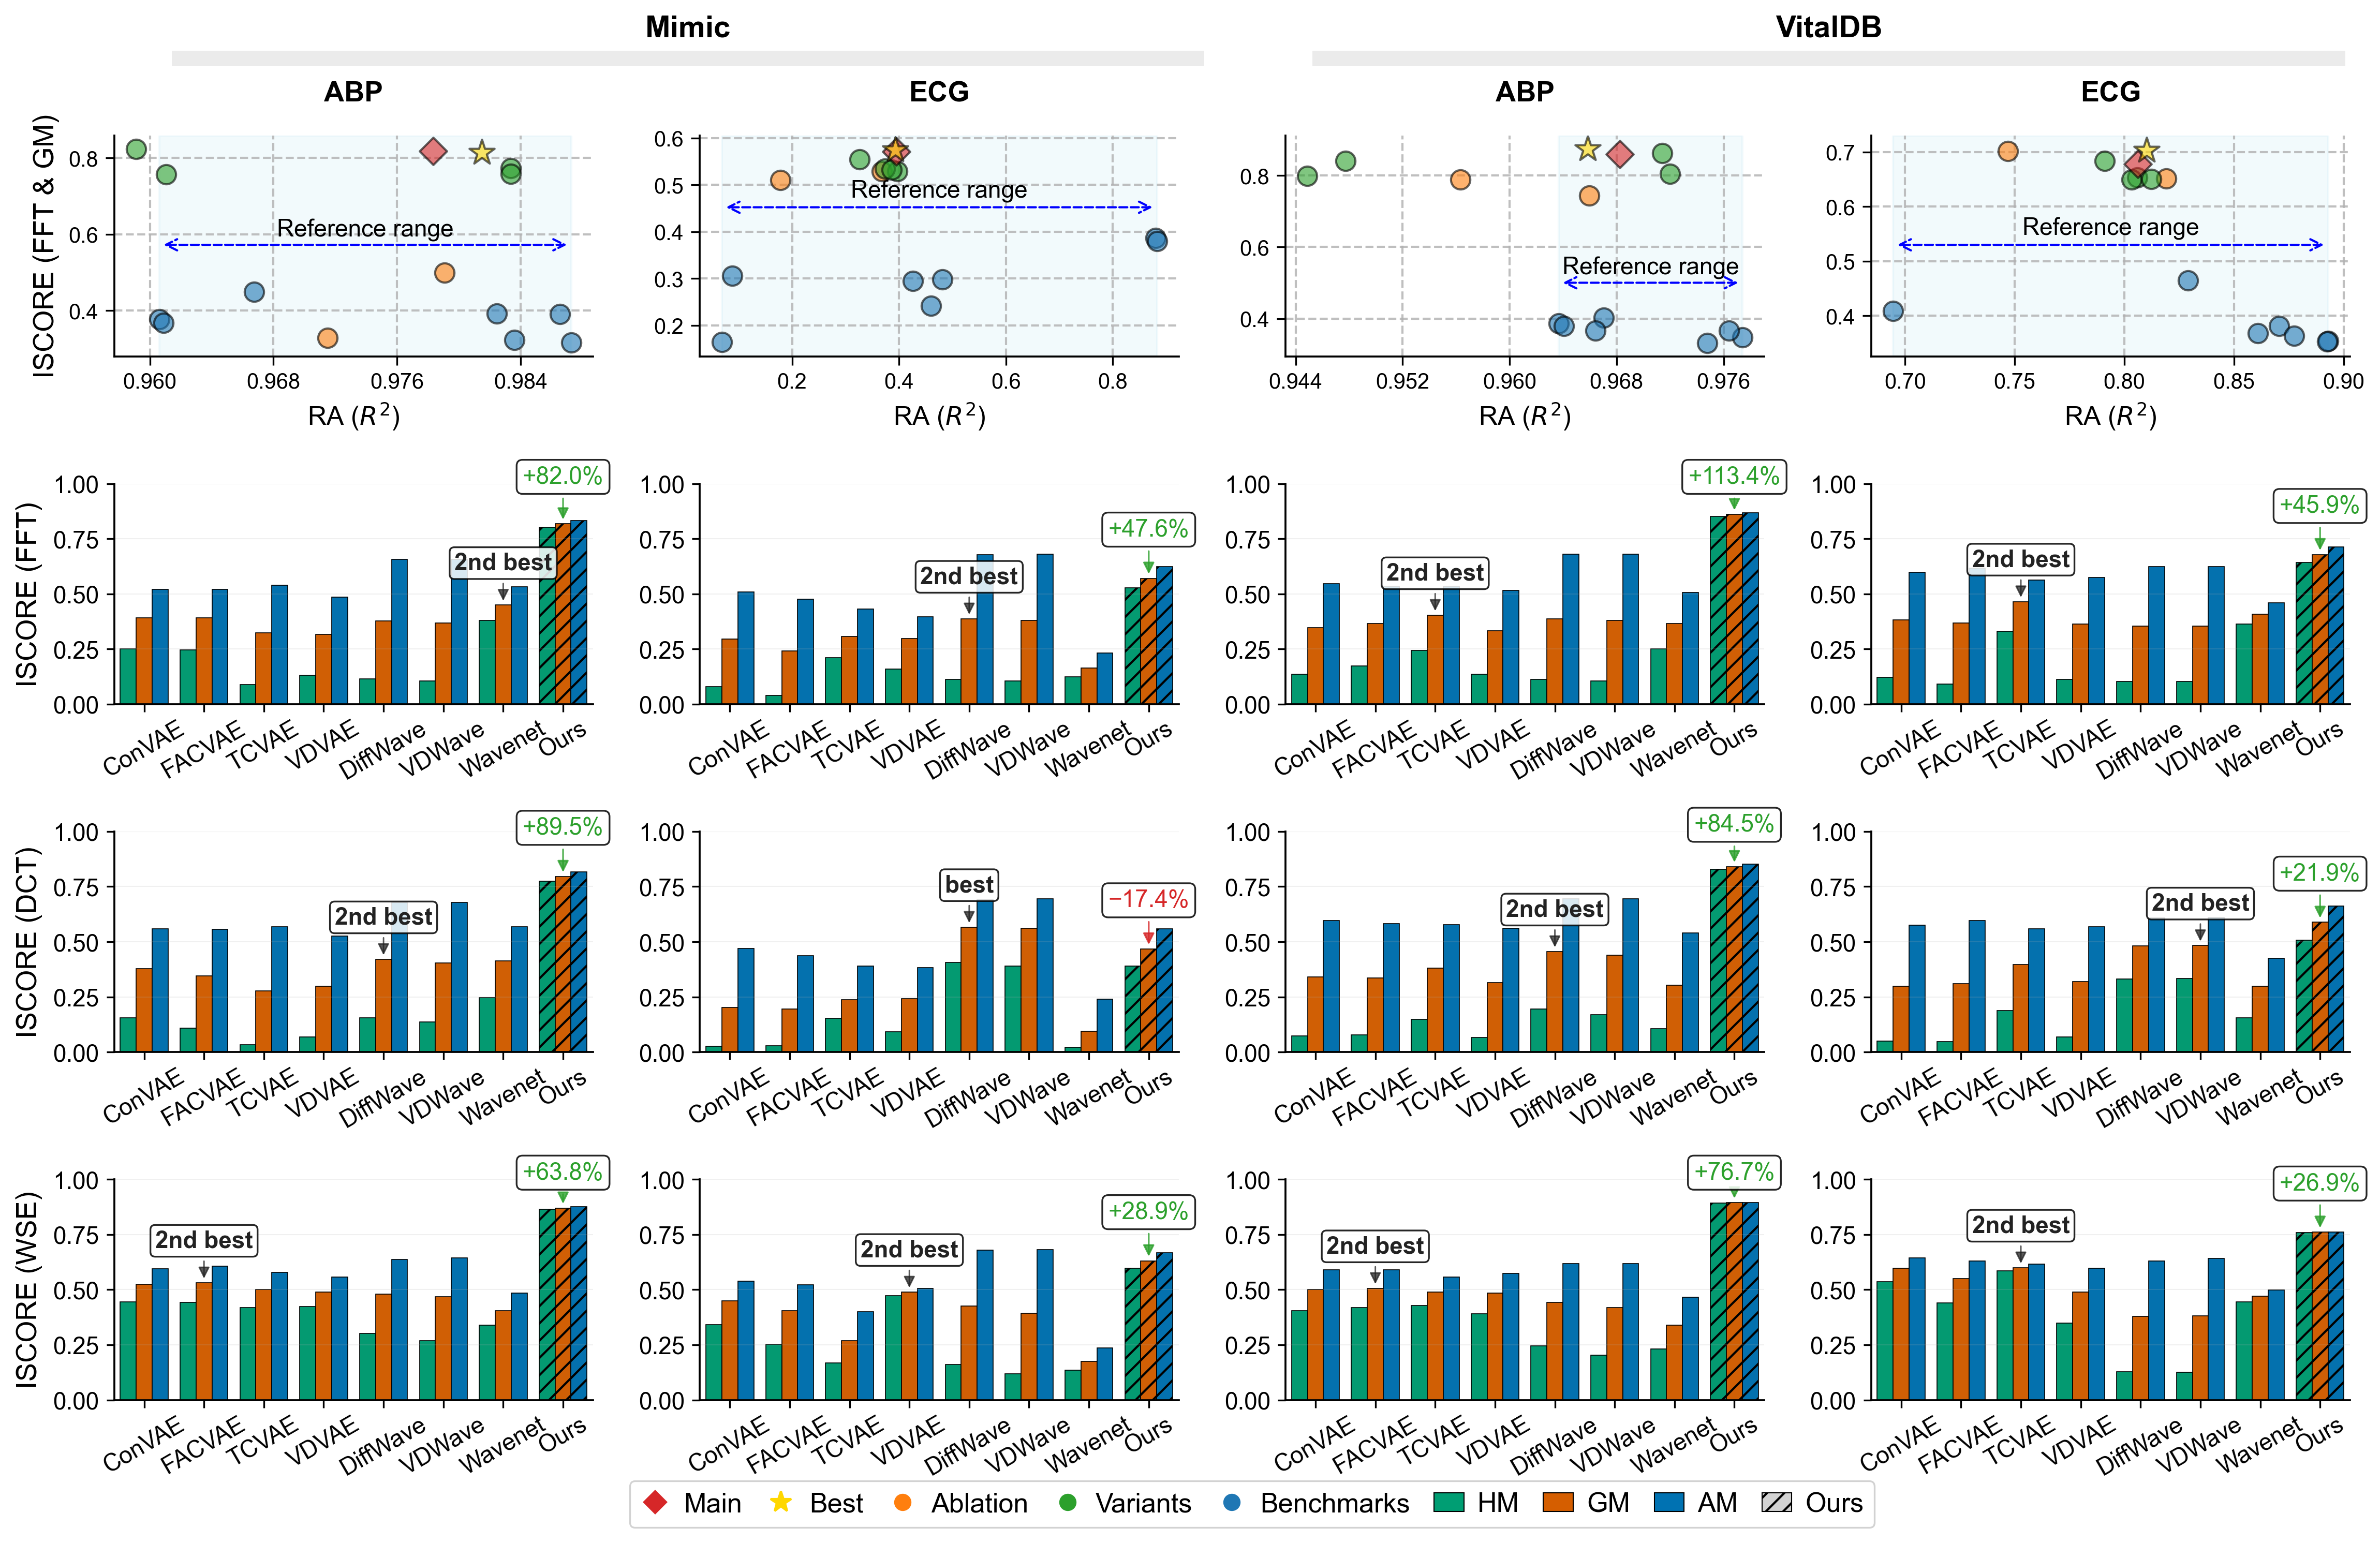

In [3]:
# -*- coding: utf-8 -*-
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.patches import Patch, Rectangle
import numpy as np

# Data preprocessing
df = BenchCompTabs.copy()

model_order = ['ConVAE','FACVAE','TCVAE','VDVAE',
               'DiffWave','VDWave','Wavenet','Ours']

def get_base_model(name):
    for base in ['ConVAE','FACVAE','TCVAE','VDVAE','DiffWave','VDWave','Wavenet','SKZ','FC']:
        if isinstance(name, str) and base in name:
            return 'Ours' if base == 'SKZ' or base == 'FC' else base
    return str(name)

df['ModelName'] = df['Model'].apply(get_base_model)
df = df[df['ModelName'].isin(model_order)].copy()
df['ModelName'] = pd.Categorical(df['ModelName'], categories=model_order, ordered=True)

# Prepare model categorization data
MainModels = df[df['Model'].isin(main_models)][['MetricType', 'Model', 'Source', 'Type', 'RA', 'ISCOREgm']]
BenchModels = df[~df['Model'].isin(main_models)][['MetricType', 'Model', 'Source', 'Type', 'RA', 'ISCOREgm']]
AblModels = AblCompTabs[['MetricType', 'Model', 'Source', 'Type', 'RA', 'ISCOREgm']]
SenseModels = SenseAccMItable[['MetricType', 'Model', 'Source', 'Type', 'RA', 'ISCOREgm']]

AllModels = pd.concat([MainModels, BenchModels, AblModels, SenseModels], ignore_index=True)
AllModels = AllModels.drop_duplicates().reset_index(drop=True)
AllModels = AllModels[AllModels['MetricType'] =='fft'].reset_index(drop=True)

AllModels['ModelName'] = AllModels['Model'].apply(get_base_model)

# Categorize models
AllModels['Category'] = 'Benchmarks'
AllModels.loc[AllModels['Model'].isin(main_models), 'Category'] = 'Main'
AllModels.loc[AllModels['Model'].isin(SenseModels['Model'].unique()), 'Category'] = 'Variants'
AllModels.loc[AllModels['Model'].isin([i for i in AblModels['Model'].unique() if 'SKZFC' not in i]), 'Category'] = 'Ablation'
AllModels.loc[AllModels['Model'].isin(best_models), 'Category'] = 'Best'

# Prepare bar chart data
df_melted = df.melt(
    id_vars=['MetricType','ModelName','Source','Type'],
    value_vars=['ISCOREam','ISCOREgm','ISCOREhm'],
    var_name='ISCORE_Metric',
    value_name='Score'
).dropna(subset=['Score'])

df_melted['SourceType'] = df_melted['Source'] + ' : ' + df_melted['Type']
all_st = sorted(df_melted['SourceType'].unique())
source_type_order = all_st[:4]

metric_name_map = {
    "fft": "FFT",
    "matching_pursuit": "DCT", 
    "welch_evo": "WSE"
}
metric_type_order = sorted(df_melted['MetricType'].unique())
row_metrics = metric_type_order[:3]
df_melted['MetricType'] = df_melted['MetricType'].map(lambda x: metric_name_map.get(x, x))

# Manual position override for reference ranges (optional)
MANUAL_REFERENCE_POSITIONS = {}

def find_optimal_reference_position(ax, x_min, x_max, y_min, y_max, points_x, points_y, num_levels=10):
    """Find optimal y position for reference range annotation to avoid overlap with data points"""
    y_range = y_max - y_min
    y_levels = np.linspace(y_min + y_range * 0.15, y_max - y_range * 0.05, num_levels)
    
    best_y = y_levels[-1]
    min_conflicts = float('inf')
    
    text_height = y_range * 0.08
    arrow_clearance = y_range * 0.02
    
    for y_pos in y_levels:
        conflicts = 0
        for px, py in zip(points_x, points_y):
            if x_min <= px <= x_max and abs(py - y_pos) < text_height + arrow_clearance:
                conflicts += 1
        
        if conflicts < min_conflicts:
            min_conflicts = conflicts
            best_y = y_pos
            
        if conflicts == 0:
            best_y = y_pos
            break
    
    return best_y

# Figure styling
plt.style.use('default')
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial","DejaVu Sans"],
    "font.size": 13,
    "axes.titlesize": 15,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 10,
    "axes.linewidth": 0.9,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.facecolor": "white",
    "figure.facecolor": "white",
    "xtick.major.size": 4,
    "ytick.major.size": 4,
    "xtick.major.width": 0.8,
    "ytick.major.width": 0.8,
    "figure.dpi": 300,
})

metric_palette = {
    "ISCOREam": "#0072B2",
    "ISCOREgm": "#D55E00",
    "ISCOREhm": "#009E73",
}
label_map = {'ISCOREam': 'AM', 'ISCOREgm': 'GM', 'ISCOREhm': 'HM'}

category_colors = {
    'Ablation':   'tab:orange',
    'Variants':   'tab:green', 
    'Benchmarks': 'tab:blue',
    'Best':       'gold',
    'Main':       'tab:red'
}
DEFAULT_MARKER = 'o'
MAIN_MARKER = 'D'
BEST_MARKER = '*'

# Create figure
fig = plt.figure(figsize=(16, 10))
fig.patch.set_facecolor('white')

# Top row: Scatter plots
combinations = []
for source_type in source_type_order:
    if ' : ' in source_type:
        source, type_name = source_type.split(' : ')
        combinations.append([type_name, source])

scatter_axes = []
for c in range(4):
    ax = plt.subplot2grid((4, 4), (0, c), fig=fig)
    scatter_axes.append(ax)

for c in range(min(4, len(combinations))):
    ax = scatter_axes[c]
    
    if c >= len(combinations):
        ax.set_visible(False)
        continue
        
    t, s = combinations[c]
    subset = AllModels[(AllModels['Type'] == t) & (AllModels['Source'] == s)]
    
    if subset.empty:
        ax.set_visible(False)
        continue
    
    # Shade benchmark range
    bench = subset[subset['Category'] == 'Benchmarks']
    if not bench.empty and len(bench) > 1:
        bmin, bmax = bench['RA'].min(), bench['RA'].max()
        ax.axvspan(bmin, bmax, color='skyblue', alpha=0.1)
    
    # Plot points by category
    cats = sorted(subset['Category'].unique(), 
                  key=lambda x: (2 if x == 'Best' else 1 if x == 'Main' else 0))
    plotted_points_x = []
    plotted_points_y = []
    
    for cat in cats:
        grp = subset[subset['Category'] == cat]
        if grp.empty:
            continue
            
        color = category_colors.get(cat, 'gray')
        marker = MAIN_MARKER if cat == 'Main' else BEST_MARKER if cat == 'Best' else DEFAULT_MARKER
        marker_size = 150 if marker == '*' else 80
        zorder_val = 15 if cat == 'Best' else 10 if cat == 'Main' else 5
        
        ax.scatter(
            grp['RA'], grp['ISCOREgm'],
            color=color, marker=marker, s=marker_size, alpha=0.6,
            edgecolors='black', 
            zorder=zorder_val
        )
        
        plotted_points_x.extend(grp['RA'].tolist())
        plotted_points_y.extend(grp['ISCOREgm'].tolist())
    
    # Add reference range annotation
    if not bench.empty and len(bench) > 1:
        bmin, bmax = bench['RA'].min(), bench['RA'].max()
        y_lims = ax.get_ylim()
        y_min, y_max = y_lims[0], y_lims[1]
        
        manual_key = (t, s)
        if manual_key in MANUAL_REFERENCE_POSITIONS:
            y_ratio = MANUAL_REFERENCE_POSITIONS[manual_key]
            y_pos = y_min + (y_max - y_min) * y_ratio
        else:
            y_pos = find_optimal_reference_position(
                ax, bmin, bmax, y_min, y_max, 
                plotted_points_x, plotted_points_y
            )
        
        ax.annotate(
            '', xy=(bmin, y_pos), xytext=(bmax, y_pos),
            arrowprops=dict(arrowstyle='<->', linestyle='--', color='blue', lw=1),
            annotation_clip=False
        )
        
        ax.text(
            (bmin + bmax) / 2, y_pos+0.01, 'Reference range',
            ha='center', va='bottom',
            fontsize=11, color='black'
        )

    ax.set_ylim(ax.get_ylim()[0]- 0.01, ax.get_ylim()[1] + 0.01) 
    ax.set_facecolor('white')
    ax.set_xlabel(r'RA ($R^2$)', fontsize=12)
    ax.set_ylabel('ISCORE (FFT & GM)' if c == 0 else '', fontsize=13)
    ax.grid(True, linestyle='--', alpha=0.8, linewidth=1.0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize=10)
    
    # Set title
    type_only = source_type_order[c].split(' : ')[-1] if c < len(source_type_order) and ' : ' in source_type_order[c] else source_type_order[c] if c < len(source_type_order) else ""
    if type_only == 'ART':
        type_only = 'ABP'
    elif type_only == 'II':
        type_only = 'ECG'
    
    ax.set_title(type_only, fontsize=13, fontweight='bold', pad=16)
    
    # Adjust x-axis
    if len(subset):
        rmse_vals = subset['RA'].values
        if len(rmse_vals) > 0:
            mn, mx = rmse_vals.min(), rmse_vals.max()
            if mn != mx:
                pad = (mx - mn) * 0.05
                ax.set_xlim(mn - pad, mx + pad)
            ax.xaxis.set_major_locator(plt.MaxNLocator(5))

# Bottom 3 rows: Bar charts
mapped_row_names = [metric_name_map.get(m, m) for m in row_metrics]

bar_axes = []
for r in range(3):
    row_axes = []
    for c in range(4):
        ax = plt.subplot2grid((4, 4), (r+1, c), fig=fig)
        row_axes.append(ax)
    bar_axes.append(row_axes)

for r in range(min(3, len(mapped_row_names))):
    for c in range(min(4, len(source_type_order))):
        ax = bar_axes[r][c]
        
        metric_label = mapped_row_names[r]
        source_type = source_type_order[c]
        
        sub_data = df_melted[
            (df_melted['MetricType'] == metric_label) &
            (df_melted['SourceType'] == source_type)
        ]
        
        if sub_data.empty:
            ax.set_visible(False)
            continue
            
        sns.barplot(
            data=sub_data,
            x='ModelName', y='Score', hue='ISCORE_Metric',
            order=model_order,
            hue_order=['ISCOREhm','ISCOREgm','ISCOREam'],
            palette=metric_palette,
            ax=ax,
            errorbar=None,
            edgecolor='black',
            linewidth=0.4,
            saturation=0.95
        )
        
        ax.set_facecolor('white')
        ax.grid(axis='y', linestyle='-', linewidth=0.5, alpha=0.18, zorder=0)
        ax.set_ylim(0.0, 1.0)
        ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
        ax.spines['left'].set_linewidth(0.9)
        ax.spines['bottom'].set_linewidth(0.9)
        ax.set_xlabel("")
        ax.set_ylabel(f"ISCORE ({metric_label})" if c == 0 else "", labelpad=5, fontsize=13)
        ax.tick_params(axis='x', labelsize=11, rotation=30, length=3.5, width=0.8, pad=2.5)
        ax.tick_params(axis='y', labelsize=11, length=3.5, width=0.8)
        plt.setp(ax.get_xticklabels(), ha='center')
        
        # Add hatching to 'Ours' bars
        if 'Ours' in model_order:
            our_index = model_order.index('Ours')
            for patch in ax.patches:
                x_pos = patch.get_x() + patch.get_width() / 2
                bar_group = int(x_pos + 0.5)
                if bar_group == our_index:
                    patch.set_hatch('///')
        
        if ax.get_legend():
            ax.get_legend().remove()
        

# Add group headers (Mimic / VitalDB)
if len(source_type_order) >= 4:
    pos_0 = scatter_axes[0].get_position()
    pos_1 = scatter_axes[1].get_position()
    pos_2 = scatter_axes[2].get_position()
    pos_3 = scatter_axes[3].get_position()
    
    group1_x0 = pos_0.x0 - 0.02; group1_x1 = pos_1.x1 + 0.025
    group2_x0 = pos_2.x0 + 0.035; group2_x1 = pos_3.x1 + 0.08
    
    bar_height = 0.01
    top_y = pos_0.y1 + 0.05
    
    rect1 = Rectangle((group1_x0, top_y), group1_x1 - group1_x0, bar_height,
                      transform=fig.transFigure, facecolor="#cfcfcf", alpha=0.4, zorder=0)
    rect2 = Rectangle((group2_x0, top_y), group2_x1 - group2_x0, bar_height,
                      transform=fig.transFigure, facecolor="#cfcfcf", alpha=0.4, zorder=0)
    fig.patches.extend([rect1, rect2])
    
    fig.text((group1_x0 + group1_x1)/2, top_y + bar_height + 0.005, "Mimic",
             ha='center', va='bottom', fontsize=14, fontweight='bold')
    fig.text((group2_x0 + group2_x1)/2, top_y + bar_height + 0.005, "VitalDB", 
             ha='center', va='bottom', fontsize=14, fontweight='bold')

# Add performance comparison annotations
def annotate_gm_diff_4x4(bar_axes, df_long, model_order, mapped_row_names, source_type_order):
    POS_COLOR = "#2ca02c"
    NEG_COLOR = "#d62728"
    NEU_COLOR = "#222222"
    
    bbox_style = dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.85, linewidth=0.8)
    bbox_style_cmp = dict(boxstyle="round,pad=0.20", facecolor="white", alpha=0.85, linewidth=0.8)
    base_text_kwargs = dict(ha='center', va='bottom', fontsize=11)
    
    for r in range(min(3, len(mapped_row_names))):
        for c in range(min(4, len(source_type_order))):
            ax = bar_axes[r][c]
            
            metric_label = mapped_row_names[r]
            source_type = source_type_order[c]
            
            sub = df_long[
                (df_long['MetricType'] == metric_label) &
                (df_long['SourceType'] == source_type) &
                (df_long['ISCORE_Metric'] == 'ISCOREgm')
            ].copy()
            
            if sub.empty:
                continue
                
            model_scores = sub.groupby('ModelName', as_index=False, observed=True)['Score'].mean()
            if 'Ours' not in model_scores['ModelName'].values:
                continue
                
            model_scores = model_scores.sort_values('Score', ascending=False).reset_index(drop=True)
            our_row = model_scores[model_scores['ModelName'] == 'Ours']
            if our_row.empty:
                continue
            our_val = float(our_row['Score'].values[0])
            
            if model_scores.iloc[0]['ModelName'] == 'Ours':
                if len(model_scores) < 2:
                    continue
                cmp_name = model_scores.iloc[1]['ModelName']
                cmp_val = float(model_scores.iloc[1]['Score'])
                cmp_label = "2nd best"
            else:
                cmp_name = model_scores.iloc[0]['ModelName']
                cmp_val = float(model_scores.iloc[0]['Score'])
                cmp_label = "best"
            
            if cmp_val <= 1e-12:
                continue
                
            diff_pct = (our_val - cmp_val) / cmp_val * 100.0
            sign = "+" if diff_pct >= 0 else "−"
            pct_text = f"{sign}{abs(diff_pct):.1f}%"
            pct_color = POS_COLOR if diff_pct >= 0 else NEG_COLOR
            
            if 'Ours' not in model_order or cmp_name not in model_order:
                continue
            x_idx_our = model_order.index('Ours')
            x_idx_cmp = model_order.index(cmp_name)
                
            ax.annotate(
                pct_text,
                xy=(x_idx_our, our_val),
                xytext=(x_idx_our, min(0.95, our_val + 0.14) + 0.03),
                textcoords='data',
                bbox=bbox_style,
                color=pct_color,
                zorder=10,
                arrowprops=dict(arrowstyle='-|>', lw=0.8, alpha=0.80, color=pct_color),
                **base_text_kwargs
            )
            
            ax.annotate(
                f"{cmp_label}",
                xy=(x_idx_cmp, cmp_val),
                xytext=(x_idx_cmp, min(0.95, cmp_val + 0.14)),
                textcoords='data',
                bbox=bbox_style_cmp,
                color=NEU_COLOR,
                zorder=10,
                arrowprops=dict(arrowstyle='-|>', lw=0.7, alpha=0.75, color=NEU_COLOR),
                ha='center', va='bottom', fontsize=11, fontweight='bold'
            )

annotate_gm_diff_4x4(bar_axes, df_melted, model_order, mapped_row_names, source_type_order)

# Create combined legend
bar_legend_handles = [
    Patch(facecolor=metric_palette[k], edgecolor='black', linewidth=0.5, label=label_map[k])
    for k in ['ISCOREhm', 'ISCOREgm', 'ISCOREam']
]
our_patch = Patch(facecolor='lightgray', hatch='///', edgecolor='black', 
                  linewidth=0.5, label='Ours')
bar_legend_handles.append(our_patch)

ordered_cats = ['Main', 'Best', 'Ablation', 'Variants', 'Benchmarks']
scatter_handles = []
for cat in ordered_cats:
    if cat in category_colors:
        mk = MAIN_MARKER if cat == 'Main' else BEST_MARKER if cat == 'Best' else DEFAULT_MARKER
        ms = 10 if mk == '*' else 7
        scatter_handles.append(
            mlines.Line2D([], [], color=category_colors[cat],
                          marker=mk, linestyle='None',
                          markersize=ms, label=cat)
        )

all_handles = scatter_handles + bar_legend_handles
legend = fig.legend(
    handles=all_handles,
    title=None,
    loc="lower center",
    bbox_to_anchor=(0.54, -0.02),
    ncol=len(all_handles),
    frameon=True,
    borderpad=0.4,
    handlelength=1.1,
    handletextpad=0.5,
    columnspacing=0.9,
    fontsize=12.5,
)

if legend:
    frame = legend.get_frame()
    frame.set_facecolor("white")
    frame.set_edgecolor("#808080")
    frame.set_alpha(0.35)
    frame.set_linewidth(0.8)

plt.tight_layout()
plt.tight_layout(rect=[0.03, 0.0, 1, 0.94])

# Save figure
SAVE_DIR = './PaperWork/Figures'
SAVE_NAME = 'Benchmark_comparison_and_Metric_Wise_performance.png'
os.makedirs(SAVE_DIR, exist_ok=True)
outpath = os.path.join(SAVE_DIR, SAVE_NAME)
fig.savefig(outpath, bbox_inches="tight", dpi=300, facecolor='white')
print(f"[Saved] {outpath}")
plt.show()

### Submetric Performance Analysis Across Model Categories

[Saved] ./PaperWork/Figures\Submetric_performance_analysis_across_model_categories.png


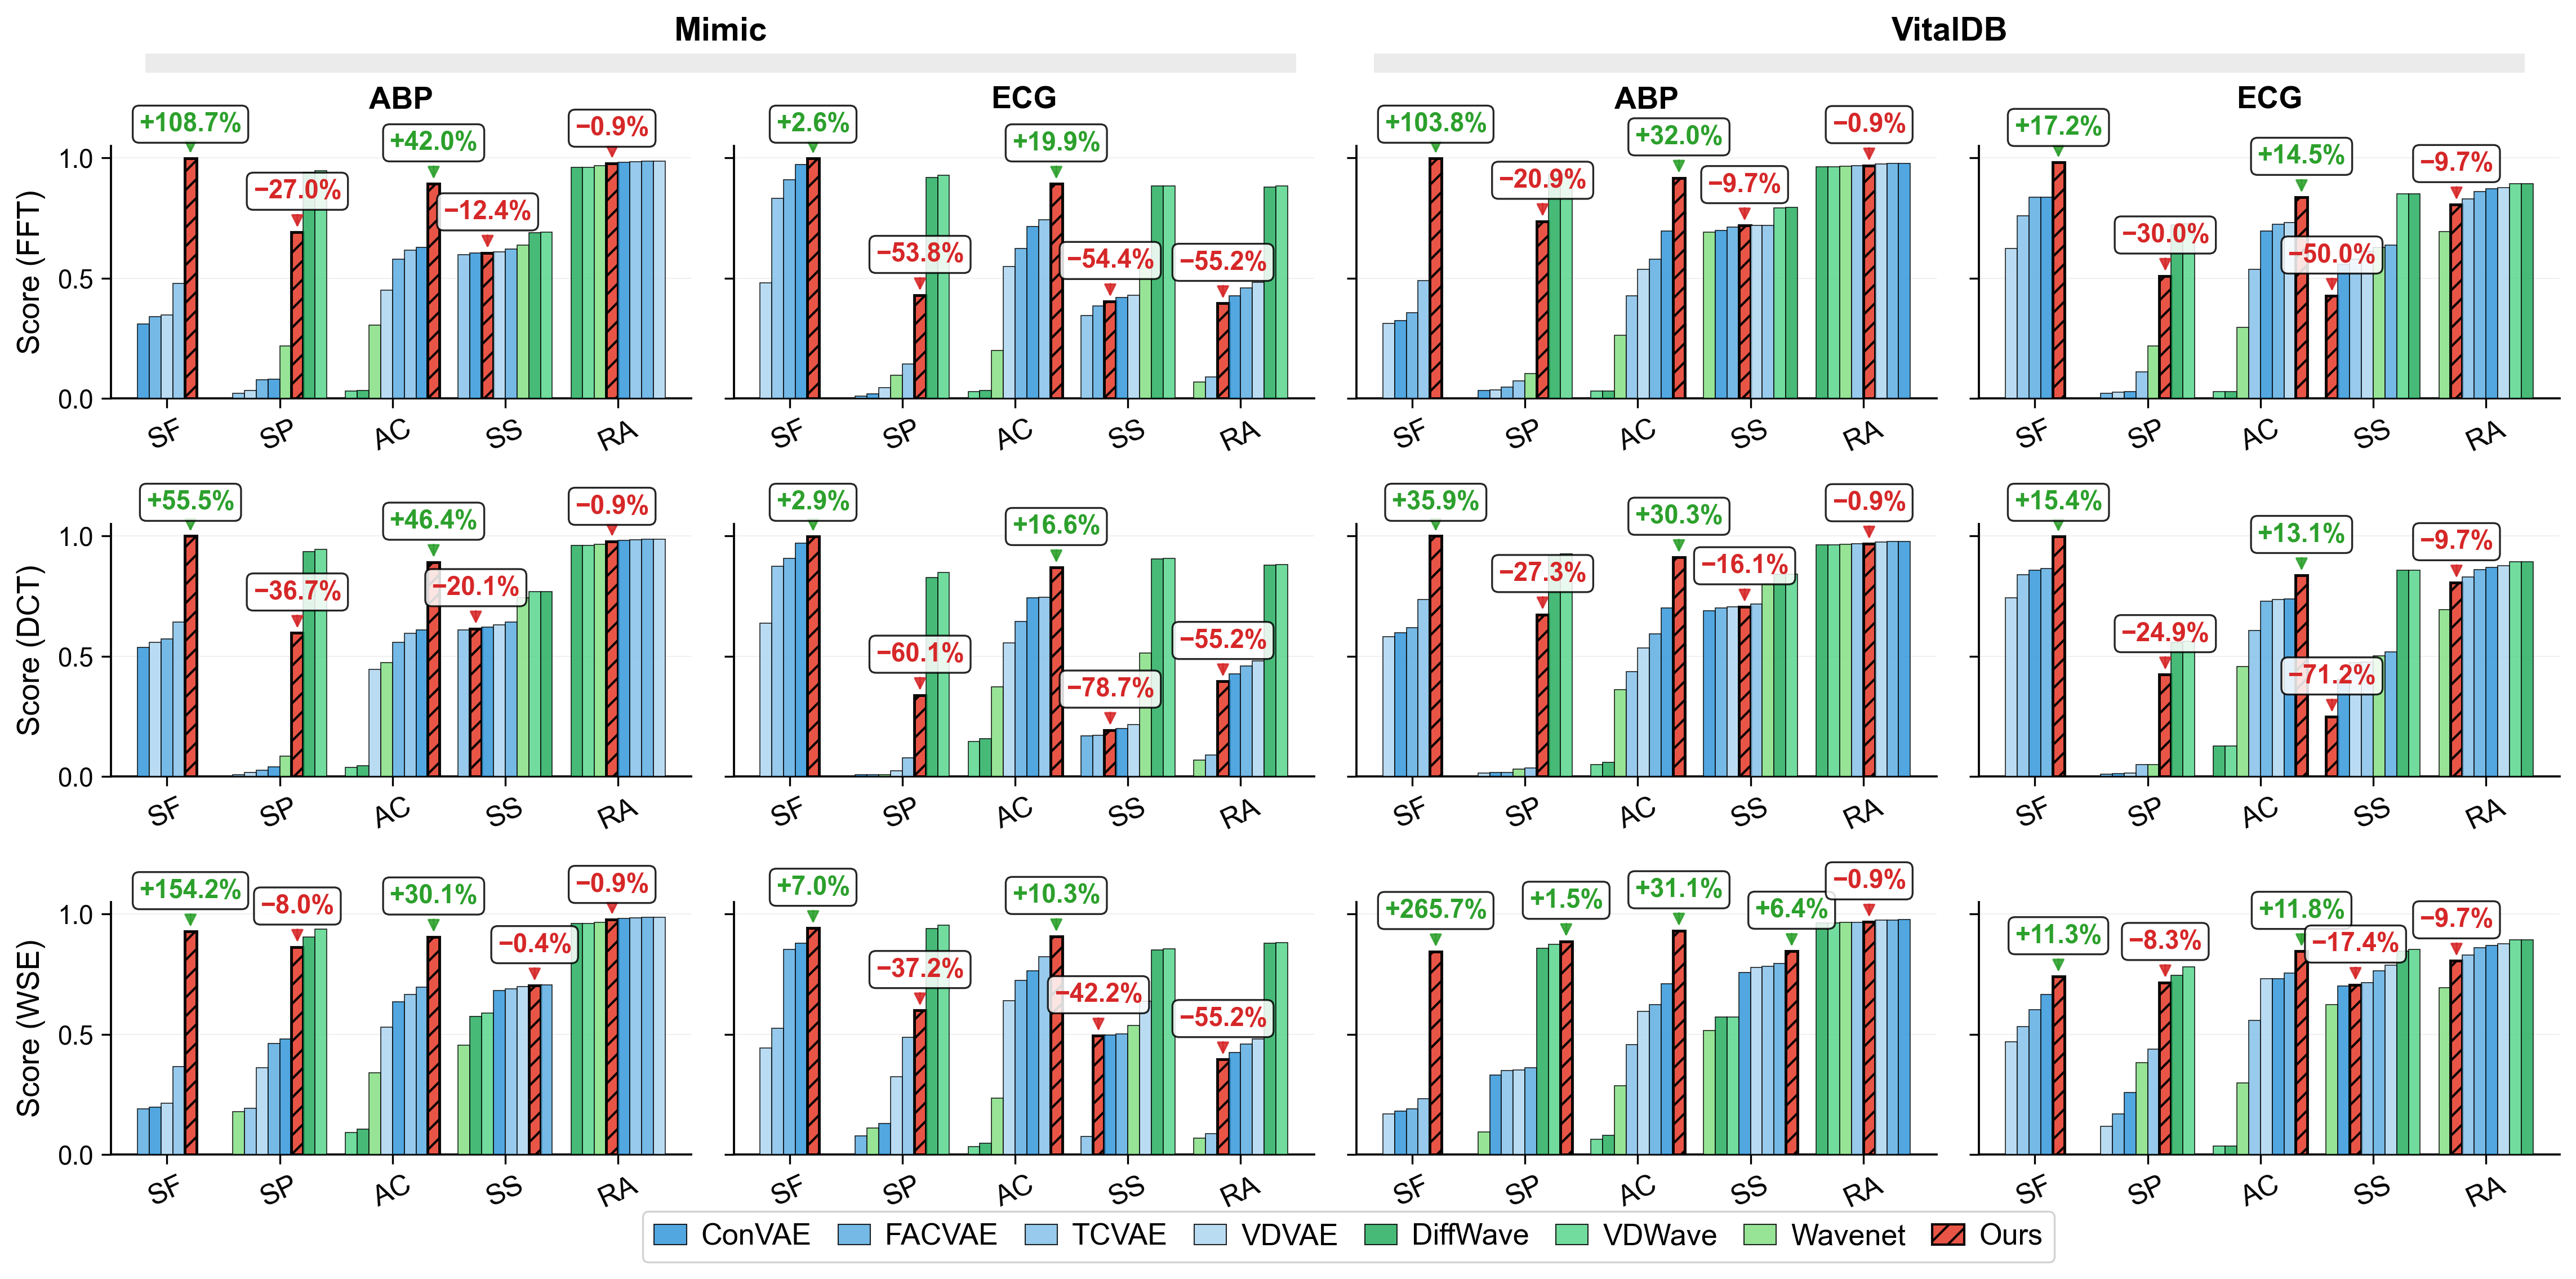

In [15]:
# -*- coding: utf-8 -*-
"""
Submetric Performance Analysis Across Model Categories
Generates facet bar plots comparing models on multiple evaluation metrics
"""
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle

POS_COLOR = "#2ca02c"
NEG_COLOR = "#d62728"

# Data loading
df = BenchCompTabs.copy()
df = df.rename(columns={'MS':'SF', 'MP':'SP'})
#df = BenchCompTabs_NOMS.copy()

# Model configuration
model_order_display = ['ConVAE','FACVAE','TCVAE','VDVAE',
                       'DiffWave','VDWave','Wavenet','Ours']

def get_base_model(name: str) -> str:
    bases = ['ConVAE','FACVAE','TCVAE','VDVAE','DiffWave','VDWave','Wavenet','SKZFC']
    for base in bases:
        if isinstance(name, str) and base in name:
            return 'Ours' if base == 'SKZFC' else base
    return str(name)

# Data preprocessing
sub_metrics = ['SF','SP','AC','SS','RA']
present_sub_metrics = [c for c in sub_metrics if c in df.columns]

df = df.copy()
df['ModelName'] = df['Model'].apply(get_base_model)
df = df[df['ModelName'].isin(model_order_display)].copy()
df['SourceType'] = df['Source'] + ' : ' + df['Type']

metric_name_map = {
    "fft": "FFT",
    "matching_pursuit": "DCT",
    "welch_evo": "WSE"
}
row_metrics_raw = sorted(df['MetricType'].dropna().unique().tolist())
row_metrics = row_metrics_raw[:3]
row_labels = [metric_name_map.get(m, m) for m in row_metrics]
col_labels = sorted(df['SourceType'].dropna().unique().tolist())

# Transform to long format
df_long = df.melt(
    id_vars=['MetricType','ModelName','SourceType'],
    value_vars=present_sub_metrics,
    var_name='SubMetric', value_name='Score'
).dropna(subset=['Score'])
df_long['MetricType'] = df_long['MetricType'].map(lambda x: metric_name_map.get(x, x))

# Figure styling
plt.style.use('default')
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial","DejaVu Sans"],
    "font.size": 13,
    "axes.titlesize": 15,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 10,
    "axes.linewidth": 0.9,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.facecolor": "white",
    "figure.facecolor": "white",
    "xtick.major.size": 4,
    "ytick.major.size": 4,
    "xtick.major.width": 0.8,
    "ytick.major.width": 0.8,
    "figure.dpi": 300,
})

# Model color scheme - VAE/Wave category distinction
COLOR_BY_MODEL = {
    # VAE family - blue tones
    'ConVAE': "#3498DB",
    'FACVAE': "#5DADE2",
    'TCVAE': "#85C1E9",
    'VDVAE': "#AED6F1",
    
    # Wave family - green tones
    'DiffWave': "#27AE60",
    'VDWave': "#58D68D",
    'Wavenet': "#85E085",
    
    # Our model - emphasis color
    'Ours': "#E74C3C",
}

def get_edge_width(model_name):
    return 1.2 if str(model_name) == 'Ours' else 0.4

def get_alpha(model_name):
    return 0.95 if str(model_name) == 'Ours' else 0.85

# Annotation styling
bbox_style = dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.85, linewidth=0.8)
base_text_kwargs = dict(ha='center', va='bottom', fontsize=11, fontweight='bold')

def _format_pm_pct(delta: float) -> str:
    sign = '+' if delta >= 0 else '−'
    return f"{sign}{abs(delta):.1f}%"

def _safe_rel_diff(our: float, ref: float):
    if ref is None or np.isclose(ref, 0.0):
        return None
    return (our - ref) / ref * 100.0

# Create figure
n_rows, n_cols = len(row_labels), len(col_labels)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 7.5), squeeze=False)
fig.patch.set_facecolor('white')

BAR_WIDTH = 0.12
Y_MAX = 1.05
GROUP_SPACING = 1.15

for r, metric in enumerate(row_labels):
    for c, srctype in enumerate(col_labels):
        ax = axes[r, c]
        sub = df_long[(df_long['MetricType'] == metric) & (df_long['SourceType'] == srctype)]
        ax.set_facecolor('white')
        ax.grid(axis='y', linestyle='-', linewidth=0.5, alpha=0.18, zorder=0)

        xticks = np.arange(len(present_sub_metrics)) * GROUP_SPACING
        ax.set_xticks(xticks)
        ax.set_xticklabels(present_sub_metrics, rotation=25, ha='center', fontsize=12)

        ax.set_ylim(0, Y_MAX)
        ax.spines['left'].set_linewidth(0.9)
        ax.spines['bottom'].set_linewidth(0.9)
        
        if c == 0:
            ax.set_ylabel(f"Score ({metric})", labelpad=5)
        else:
            ax.set_ylabel("")
            
        if r == 0:
            type_only = srctype.split(' : ')[-1]
            if type_only == 'ART':
                type_only = 'ABP'
            elif type_only == 'II':
                type_only = 'ECG'
            ax.set_title(type_only, fontsize=13, fontweight='bold', pad=16)

        # Plot bars sorted by score (ascending)
        for j, sm in enumerate(present_sub_metrics):
            sub_sm = sub[sub['SubMetric'] == sm]
            if sub_sm.empty:
                continue

            mvals = (sub_sm.groupby('ModelName', as_index=False, observed=True)['Score']
                              .mean()
                              .sort_values('Score', ascending=True))
            models_sorted = mvals['ModelName'].tolist()
            scores_sorted = mvals['Score'].tolist()
            n_bars = len(models_sorted)
            if n_bars == 0:
                continue

            total_width = BAR_WIDTH * n_bars
            start = xticks[j] - total_width/2 + BAR_WIDTH/2
            xs = start + BAR_WIDTH * np.arange(n_bars)

            # Draw bars
            for x, model, val in zip(xs, models_sorted, scores_sorted):
                color = COLOR_BY_MODEL.get(str(model), '#888888')
                hatch = '///' if str(model) == 'Ours' else None
                edge_width = get_edge_width(model)
                alpha = get_alpha(model)
                
                ax.bar(x, float(val),
                       width=BAR_WIDTH,
                       color=color,
                       edgecolor='black', 
                       linewidth=edge_width,
                       hatch=hatch, 
                       alpha=alpha,
                       zorder=3)

            # Performance comparison annotations
            if 'Ours' in models_sorted:
                idx_our = models_sorted.index('Ours')
                our_val = float(scores_sorted[idx_our])

                idx_best = n_bars - 1
                idx_2nd = n_bars - 2 if n_bars >= 2 else None

                # Compare with best or 2nd best
                if idx_our == idx_best and idx_2nd is not None:
                    ref_idx = idx_2nd
                else:
                    ref_idx = idx_best

                ref_val = float(scores_sorted[ref_idx]) if ref_idx is not None else None
                rel = _safe_rel_diff(our_val, ref_val)

                if rel is not None:
                    pct_text = f"{_format_pm_pct(rel)}"
                    x_our = float(xs[idx_our])

                    y_text = our_val + 0.06
                    if y_text > (Y_MAX - 0.02):
                        y_text = min(Y_MAX - 0.02, our_val + 0.035)

                    pct_color = POS_COLOR if rel >= 0 else NEG_COLOR

                    ax.annotate(
                        pct_text,
                        xy=(x_our, our_val),
                        xytext=(x_our, y_text+0.06),
                        textcoords='data',
                        bbox=bbox_style,
                        color=pct_color,
                        zorder=10,
                        arrowprops=dict(arrowstyle='-|>', lw=0.8, alpha=0.85, color=pct_color),
                        **base_text_kwargs
                    )

        # Y-tick labels only on first column
        if c == 0:
            ax.tick_params(axis='y', which='both', labelleft=True)
        else:
            ax.tick_params(axis='y', which='both', labelleft=False)
            ax.set_ylabel("")


# Group headers (Mimic/VitalDB)
if n_cols >= 4:
    pos_0 = axes[0, 0].get_position()
    pos_1 = axes[0, 1].get_position()
    pos_2 = axes[0, 2].get_position()
    pos_3 = axes[0, 3].get_position()
    
    group1_x0 = pos_0.x0 - 0.03; group1_x1 = pos_1.x1 + 0.025
    group2_x0 = pos_2.x0 + 0.02; group2_x1 = pos_3.x1 + 0.075
    bar_height = 0.015
    top_y = max(ax.get_position().y1 for ax in axes[0, :]) + 0.045
    
    rect1 = Rectangle((group1_x0, top_y), group1_x1 - group1_x0, bar_height,
                      transform=fig.transFigure, facecolor="#cfcfcf", alpha=0.4, zorder=0)
    rect2 = Rectangle((group2_x0, top_y), group2_x1 - group2_x0, bar_height,
                      transform=fig.transFigure, facecolor="#cfcfcf", alpha=0.4, zorder=0)
    fig.patches.extend([rect1, rect2])
    
    fig.text((group1_x0 + group1_x1)/2, top_y + bar_height + 0.005, "Mimic",
             ha='center', va='bottom', fontsize=14, fontweight='bold')
    fig.text((group2_x0 + group2_x1)/2, top_y + bar_height + 0.005, "VitalDB",
             ha='center', va='bottom', fontsize=14, fontweight='bold')

# Legend with model categories
legend_handles = []
present_models = [m for m in model_order_display if m in df_long['ModelName'].unique()]

for m in present_models:
    edge_width = 1.0 if m == 'Ours' else 0.5
    hatch_pattern = '///' if m == 'Ours' else None
    
    legend_handles.append(
        Patch(
            facecolor=COLOR_BY_MODEL[m],
            edgecolor='black',
            linewidth=edge_width,
            label=m,
            hatch=hatch_pattern,
            alpha=get_alpha(m)
        )
    )

legend = fig.legend(
    handles=legend_handles,
    title=None,
    loc="lower center",
    bbox_to_anchor=(0.54, -0.025),
    ncol=min(8, max(1, len(present_models))),
    frameon=True, borderpad=0.4,
    handlelength=1.1, handletextpad=0.5, columnspacing=0.9,
    fontsize=12.5,
)
if legend:
    frame = legend.get_frame()
    frame.set_facecolor("white")
    frame.set_edgecolor("#808080")
    frame.set_alpha(0.35)
    frame.set_linewidth(0.8)

plt.tight_layout(rect=[0.03, 0.0, 1, 0.94])

# Save figure
SAVE_DIR = './PaperWork/Figures'
SAVE_NAME = 'Submetric_performance_analysis_across_model_categories.png'
os.makedirs(SAVE_DIR, exist_ok=True)
outpath = os.path.join(SAVE_DIR, SAVE_NAME)
fig.savefig(outpath, bbox_inches="tight", dpi=300, facecolor='white')
print(f"[Saved] {outpath}")
plt.show()

### Ablation Study Performance Analysis

[Saved] ./PaperWork/Figures/Ablation_study_performance_analysis.png


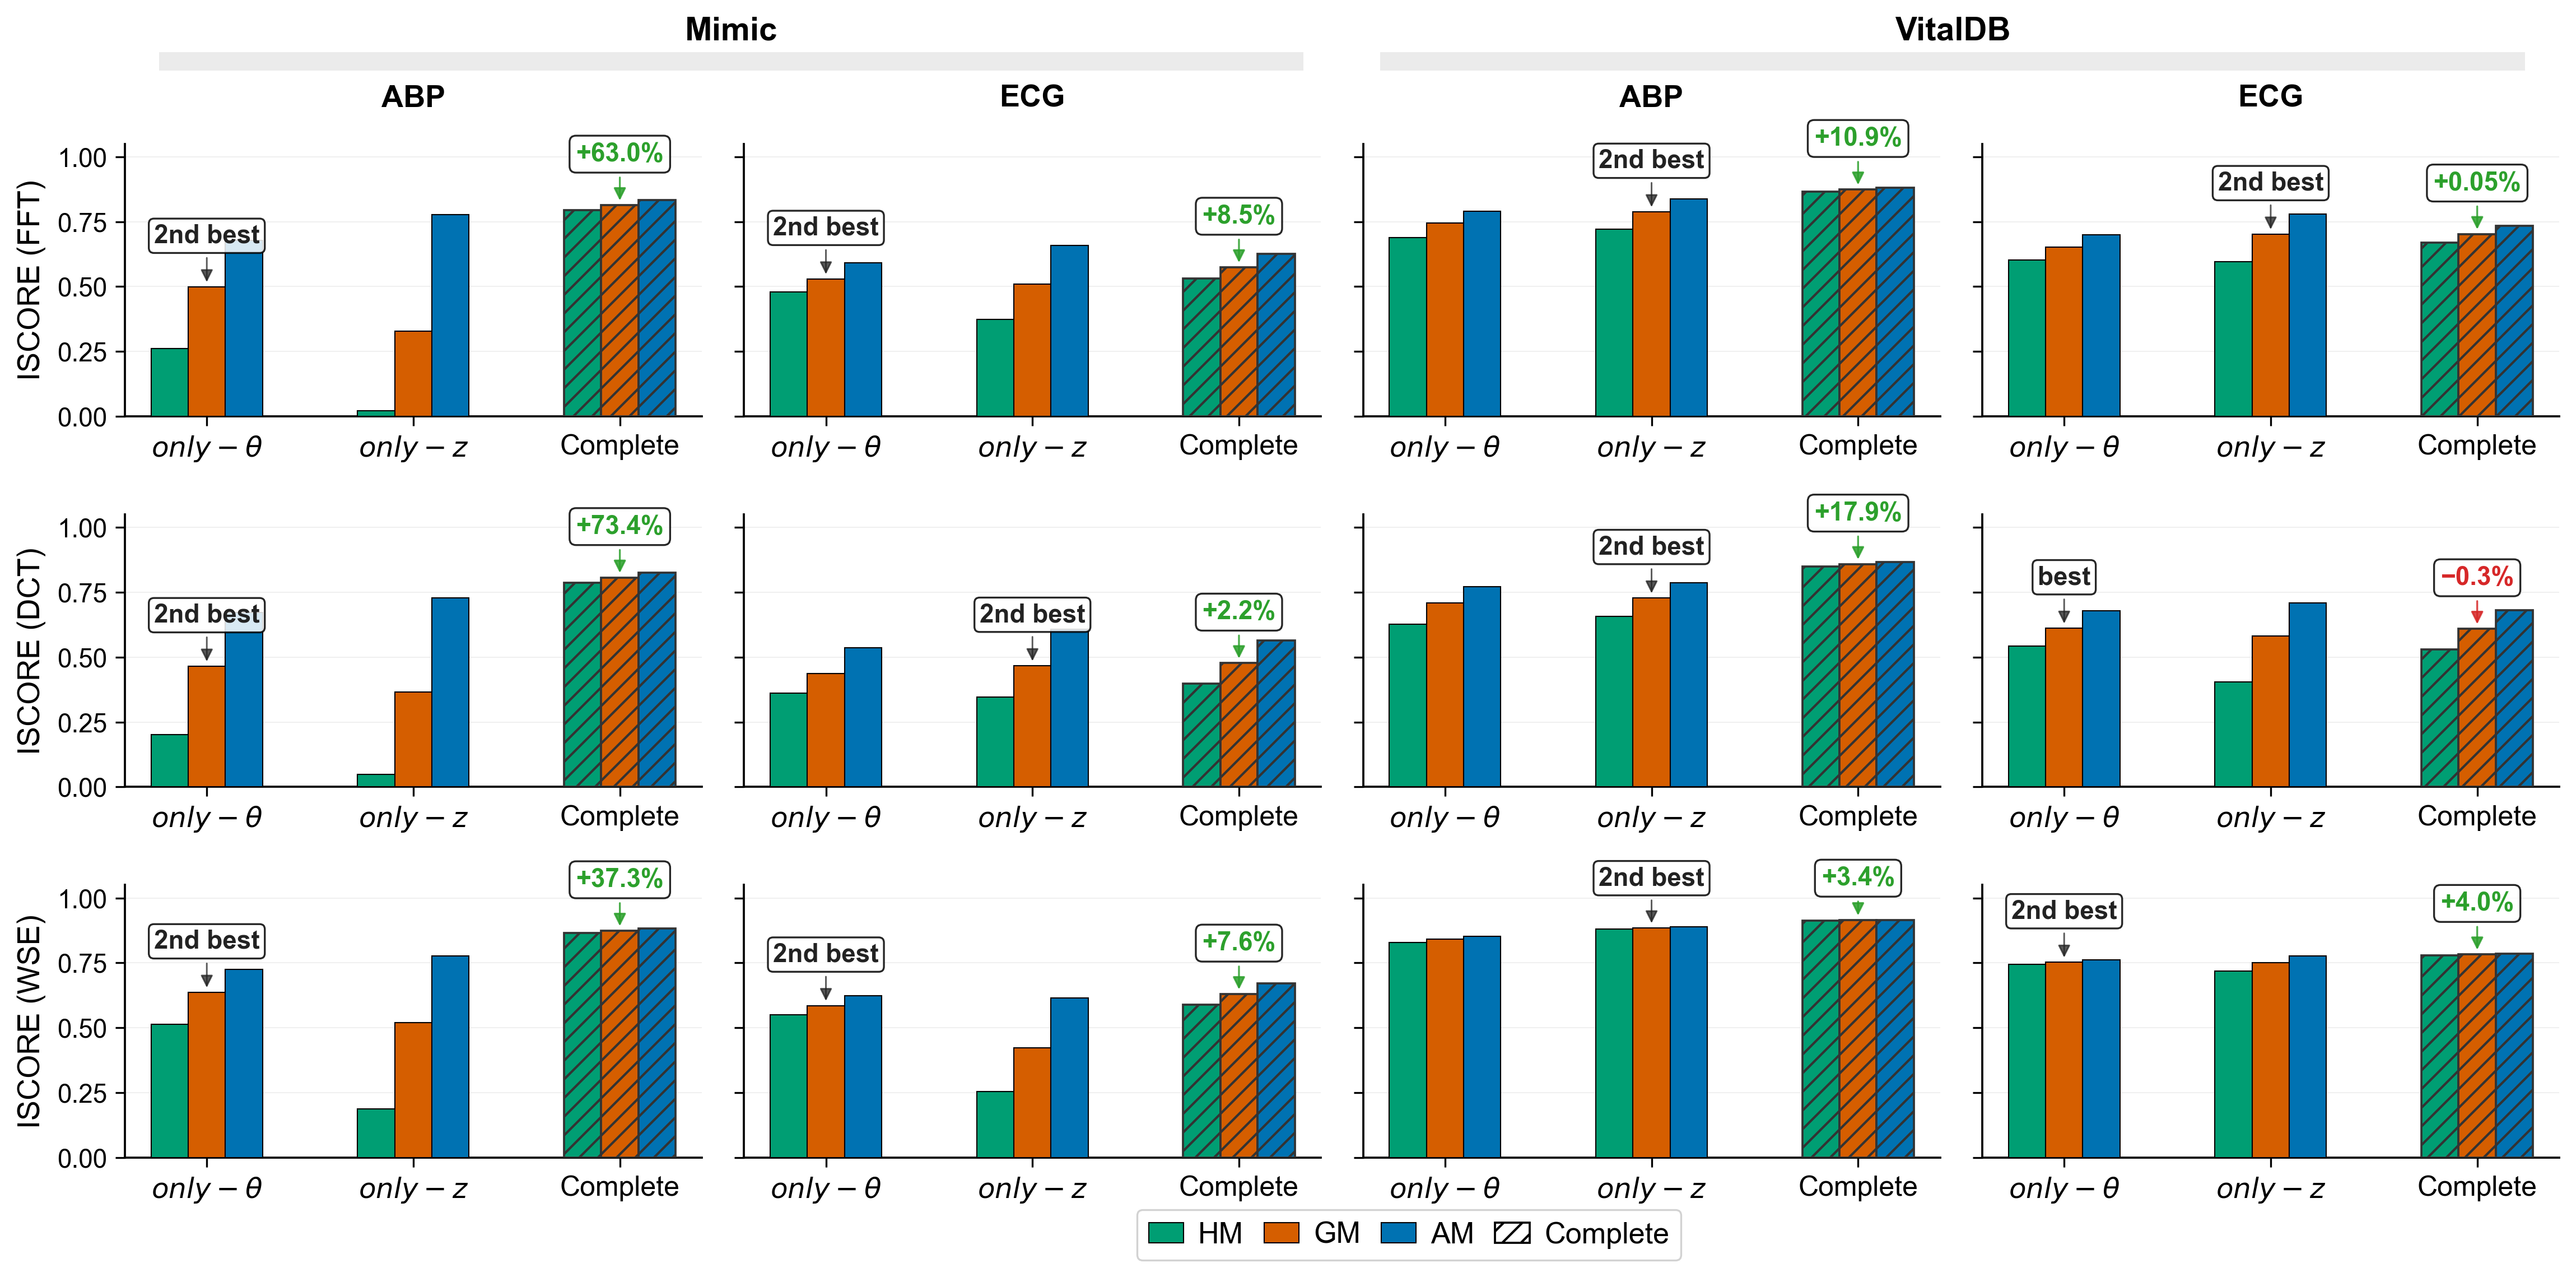

In [5]:
# -*- coding: utf-8 -*-
"""
Ablation Study Performance Analysis
3×N grid visualization comparing model variants across evaluation metrics
"""
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle

POS_COLOR = "#2ca02c"
NEG_COLOR = "#d62728"

# Metric color scheme
#METRIC_PALETTE = {'ISCOREam': "#E69F00", 'ISCOREgm': "#56B4E9", 'ISCOREhm': "#009E73"}
METRIC_PALETTE = {
    "ISCOREam": "#0072B2",
    "ISCOREgm": "#D55E00",
    "ISCOREhm": "#009E73",
}
SUBMETRIC_DISPLAY = {'ISCOREam':'AM','ISCOREgm':'GM','ISCOREhm':'HM'}

# Model configuration
MODEL_ORDER_TOP = ['FC', 'SKZ', 'Our']
MODEL_DISPLAY_MAP = {'FC': '$only-\\theta$', 'SKZ': '$only-z$', 'Our': 'Complete'}

HATCH_OUR = "///"
EDGE_LW = 1.0

# Figure styling
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial","DejaVu Sans"],
    "font.size": 13,
    "axes.titlesize": 15,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 10,
    "axes.linewidth": 0.9,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.facecolor": "white",
    "figure.facecolor": "white",
    "xtick.major.size": 4,
    "ytick.major.size": 4,
    "xtick.major.width": 0.8,
    "ytick.major.width": 0.8,
    "figure.dpi": 300,
})

bbox_style = dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.85, linewidth=0.8)
base_text_kwargs = dict(ha='center', va='bottom', fontsize=11, fontweight='bold')

def _format_pm_pct(delta: float) -> str:
    """Format percentage difference with adaptive precision"""
    sign = '+' if delta >= 0 else '−'
    abs_val = abs(delta)

    if np.isclose(abs_val, 0.0, atol=1e-12):
        return f"{sign}{abs_val:.2f}%"

    for decimals in (1, 2, 3, 4):
        txt = f"{abs_val:.{decimals}f}"
        if float(txt) != 0.0:
            return f"{sign}{txt}%"

    return f"{sign}{abs_val:.4f}%"

def _safe_rel_diff(our: float, ref: float):
    if ref is None or np.isclose(ref, 0.0):
        return None
    return (our - ref) / ref * 100.0

# Data loading and preprocessing
df = AblCompTabs.copy()

metric_name_map = {"fft": "FFT", "matching_pursuit": "DCT", "welch_evo": "WSE"}
sub_metrics = ['ISCOREhm','ISCOREgm','ISCOREam']
present_sub_metrics = [c for c in sub_metrics if c in df.columns]

def get_base_model_top(model_name: str) -> str:
    s = str(model_name)
    if 'SKZFC' in s: return 'Our'
    if 'SKZ'   in s: return 'SKZ'
    if 'FC'    in s: return 'FC'
    return s

df_top = df.copy()
df_top['ModelName'] = df_top['Model'].apply(get_base_model_top)
df_top = df_top[df_top['ModelName'].isin(MODEL_ORDER_TOP)].copy()
df_top['SourceType'] = df_top['Source'] + ' : ' + df_top['Type']
df_top['MetricType'] = df_top['MetricType'].map(lambda x: metric_name_map.get(x, x))

row_labels = ['FFT', 'DCT', 'WSE']
col_labels = sorted(df_top['SourceType'].dropna().unique().tolist())

# Transform to long format
df_long_top = df_top.melt(
    id_vars=['MetricType','ModelName','SourceType'],
    value_vars=present_sub_metrics,
    var_name='SubMetric', value_name='Score'
).dropna(subset=['Score'])

# Create figure
n_rows_top, n_cols = len(row_labels), len(col_labels)
fig, axes = plt.subplots(n_rows_top, n_cols, figsize=(16, 7.5), squeeze=False, sharey=False)

# Common styling
for ax in axes.ravel():
    ax.set_facecolor("white")
    ax.grid(axis='y', linestyle='-', linewidth=0.5, alpha=0.18, zorder=0)

BAR_WIDTH = 0.18
Y_MAX_TOP = 1.05

for r, metric in enumerate(row_labels):
    for c, srctype in enumerate(col_labels):
        ax = axes[r, c]
        ax.set_ylim(0, Y_MAX_TOP)

        sub = df_long_top[(df_long_top['MetricType'] == metric) & (df_long_top['SourceType'] == srctype)]
        xs_base = np.arange(len(MODEL_ORDER_TOP))
        ax.set_xticks(xs_base)
        ax.set_xticklabels([MODEL_DISPLAY_MAP[m] for m in MODEL_ORDER_TOP], rotation=0, ha='center', fontsize=12)

        # Submetric offsets
        k = max(1, len(present_sub_metrics))
        offsets = np.linspace(-BAR_WIDTH*(k-1)/2, BAR_WIDTH*(k-1)/2, k) if k > 1 else [0.0]

        for j, sm in enumerate(present_sub_metrics):
            sm_color = METRIC_PALETTE.get(sm, '#888888')
            for m_idx, m in enumerate(MODEL_ORDER_TOP):
                val = sub.loc[(sub['ModelName'] == m) & (sub['SubMetric'] == sm), 'Score'].mean()
                if pd.isna(val):
                    continue
                x = xs_base[m_idx] + (offsets[j] if k > 1 else 0.0)
                ax.bar(
                    x, float(val), width=BAR_WIDTH,
                    color=sm_color,
                    edgecolor=('#333333' if m == 'Our' else 'black'),
                    linewidth=(0.9 if m == 'Our' else 0.5),
                    hatch=(HATCH_OUR if m == 'Our' else None),
                    zorder=3
                )

        # Y-axis and title setup
        if c == 0:
            ax.set_ylabel(f"ISCORE ({metric})", labelpad=5)
        else:
            ax.set_ylabel("")
            ax.tick_params(axis='y', which='both', labelleft=False)

        if r == 0:
            type_only = srctype.split(' : ')[-1] if ' : ' in srctype else srctype
            if type_only == 'ART':
                type_only = 'ABP'
            elif type_only == 'II':
                type_only = 'ECG'            
            ax.set_title(type_only, fontsize=13, fontweight='bold', pad=16)

        # Performance comparison annotations (GM-based)
        if 'ISCOREgm' in present_sub_metrics:
            gm_sub = sub[sub['SubMetric'] == 'ISCOREgm']
            if not gm_sub.empty and 'Our' in gm_sub['ModelName'].unique():
                ms = (gm_sub.groupby('ModelName', as_index=False, observed=True)['Score']
                            .mean().sort_values('Score', ascending=False).reset_index(drop=True))
                if not ms.empty and 'Our' in ms['ModelName'].values:
                    our_val = float(ms.loc[ms['ModelName']=='Our','Score'].values[0])
                    if ms.iloc[0]['ModelName'] == 'Our':
                        if len(ms) >= 2:
                            cmp_name = str(ms.iloc[1]['ModelName']); cmp_val = float(ms.iloc[1]['Score']); cmp_tag="2nd best"
                        else:
                            cmp_name, cmp_val = None, None
                    else:
                        cmp_name = str(ms.iloc[0]['ModelName']); cmp_val = float(ms.iloc[0]['Score']); cmp_tag="best"

                    if cmp_name is not None and cmp_val and cmp_val > 1e-12:
                        diff = _safe_rel_diff(our_val, cmp_val)
                        if diff is not None:
                            pct_text = _format_pm_pct(diff)
                            pct_color = POS_COLOR if diff >= 0 else NEG_COLOR
                            
                            x_our = xs_base[MODEL_ORDER_TOP.index('Our')]
                            x_cmp = xs_base[MODEL_ORDER_TOP.index(cmp_name)]

                            y_text_our = min(Y_MAX_TOP - 0.02, our_val + 0.15)
                            ax.annotate(
                                pct_text, xy=(x_our, our_val), xytext=(x_our, y_text_our),
                                textcoords='data', bbox=bbox_style, color=pct_color, zorder=10,
                                arrowprops=dict(arrowstyle='-|>', lw=0.8, alpha=0.85, color=pct_color),
                                **base_text_kwargs
                            )
                            y_text_cmp = min(Y_MAX_TOP - 0.02, cmp_val + 0.15)
                            ax.annotate(
                                cmp_tag, xy=(x_cmp, cmp_val), xytext=(x_cmp, y_text_cmp),
                                textcoords='data', bbox=dict(boxstyle="round,pad=0.20", facecolor="white", alpha=0.85, edgecolor='black', linewidth=0.8),
                                color="#222222", zorder=10,
                                arrowprops=dict(arrowstyle='-|>', lw=0.7, alpha=0.75, color="#222222"),
                                ha='center', va='bottom', fontsize=11, fontweight='bold'
                            )



# Group headers (Mimic/VitalDB)
mimic_cols = [i for i, label in enumerate(col_labels) if 'Mimic' in label]
vitaldb_cols = [i for i, label in enumerate(col_labels) if 'VitalDB' in label]

if mimic_cols and vitaldb_cols:
    pos_start = axes[0, mimic_cols[0]].get_position()
    pos_end = axes[0, mimic_cols[-1]].get_position()
    group1_x0, group1_x1 = pos_start.x0 - 0.03, pos_end.x1 + 0.025
    
    pos_start = axes[0, vitaldb_cols[0]].get_position()
    pos_end = axes[0, vitaldb_cols[-1]].get_position()
    group2_x0, group2_x1 = pos_start.x0 + 0.02, pos_end.x1 + 0.075

    bar_height = 0.015
    top_y = max(ax.get_position().y1 for ax in axes[0, :]) + 0.045

    rect1 = Rectangle((group1_x0, top_y), group1_x1 - group1_x0, bar_height,
                      transform=fig.transFigure, facecolor="#cfcfcf", alpha=0.4, zorder=0)
    rect2 = Rectangle((group2_x0, top_y), group2_x1 - group2_x0, bar_height,
                      transform=fig.transFigure, facecolor="#cfcfcf", alpha=0.4, zorder=0)
    fig.patches.extend([rect1, rect2])

    fig.text((group1_x0 + group1_x1)/2, top_y + bar_height + 0.004, "Mimic",
             ha='center', va='bottom', fontsize=14, fontweight='bold')
    fig.text((group2_x0 + group2_x1)/2, top_y + bar_height + 0.004, "VitalDB",
             ha='center', va='bottom', fontsize=14, fontweight='bold')

# Legend
handles_top = []
# Submetrics
for k in ['ISCOREhm', 'ISCOREgm', 'ISCOREam']:
    if k in present_sub_metrics:
        handles_top.append(
            Patch(facecolor=METRIC_PALETTE[k], edgecolor='black', linewidth=0.5, 
                  label=SUBMETRIC_DISPLAY.get(k, k.upper()))
        )

# Complete model indicator
handles_top.append(
    Patch(facecolor='white', edgecolor='black', 
          hatch=HATCH_OUR, linewidth=0.9, label="Complete")
)

legend1 = fig.legend(
    handles=handles_top, 
    loc="lower center", bbox_to_anchor=(0.56, -0.03),
    ncol=4, frameon=True, borderpad=0.4,
    handlelength=1.2, handletextpad=0.5, columnspacing=0.7, fontsize=12.5,
)

if legend1:
    frame = legend1.get_frame()
    frame.set_facecolor("white")
    frame.set_edgecolor("#808080")
    frame.set_alpha(0.35)
    frame.set_linewidth(0.8)

plt.tight_layout(rect=[0.03, 0.0, 1, 0.94])

# Save figure
SAVE_DIR = './PaperWork/Figures/'
SAVE_NAME = 'Ablation_study_performance_analysis.png'
os.makedirs(SAVE_DIR, exist_ok=True)
outpath = os.path.join(SAVE_DIR, SAVE_NAME)
fig.savefig(outpath, bbox_inches="tight", dpi=300, facecolor='white')
print(f"[Saved] {outpath}")
plt.show()

### Performance Range Analysis and Sensitivity Study

[Saved] ./PaperWork/Figures/Performance_range_analysis_and_sensitivity_study.png


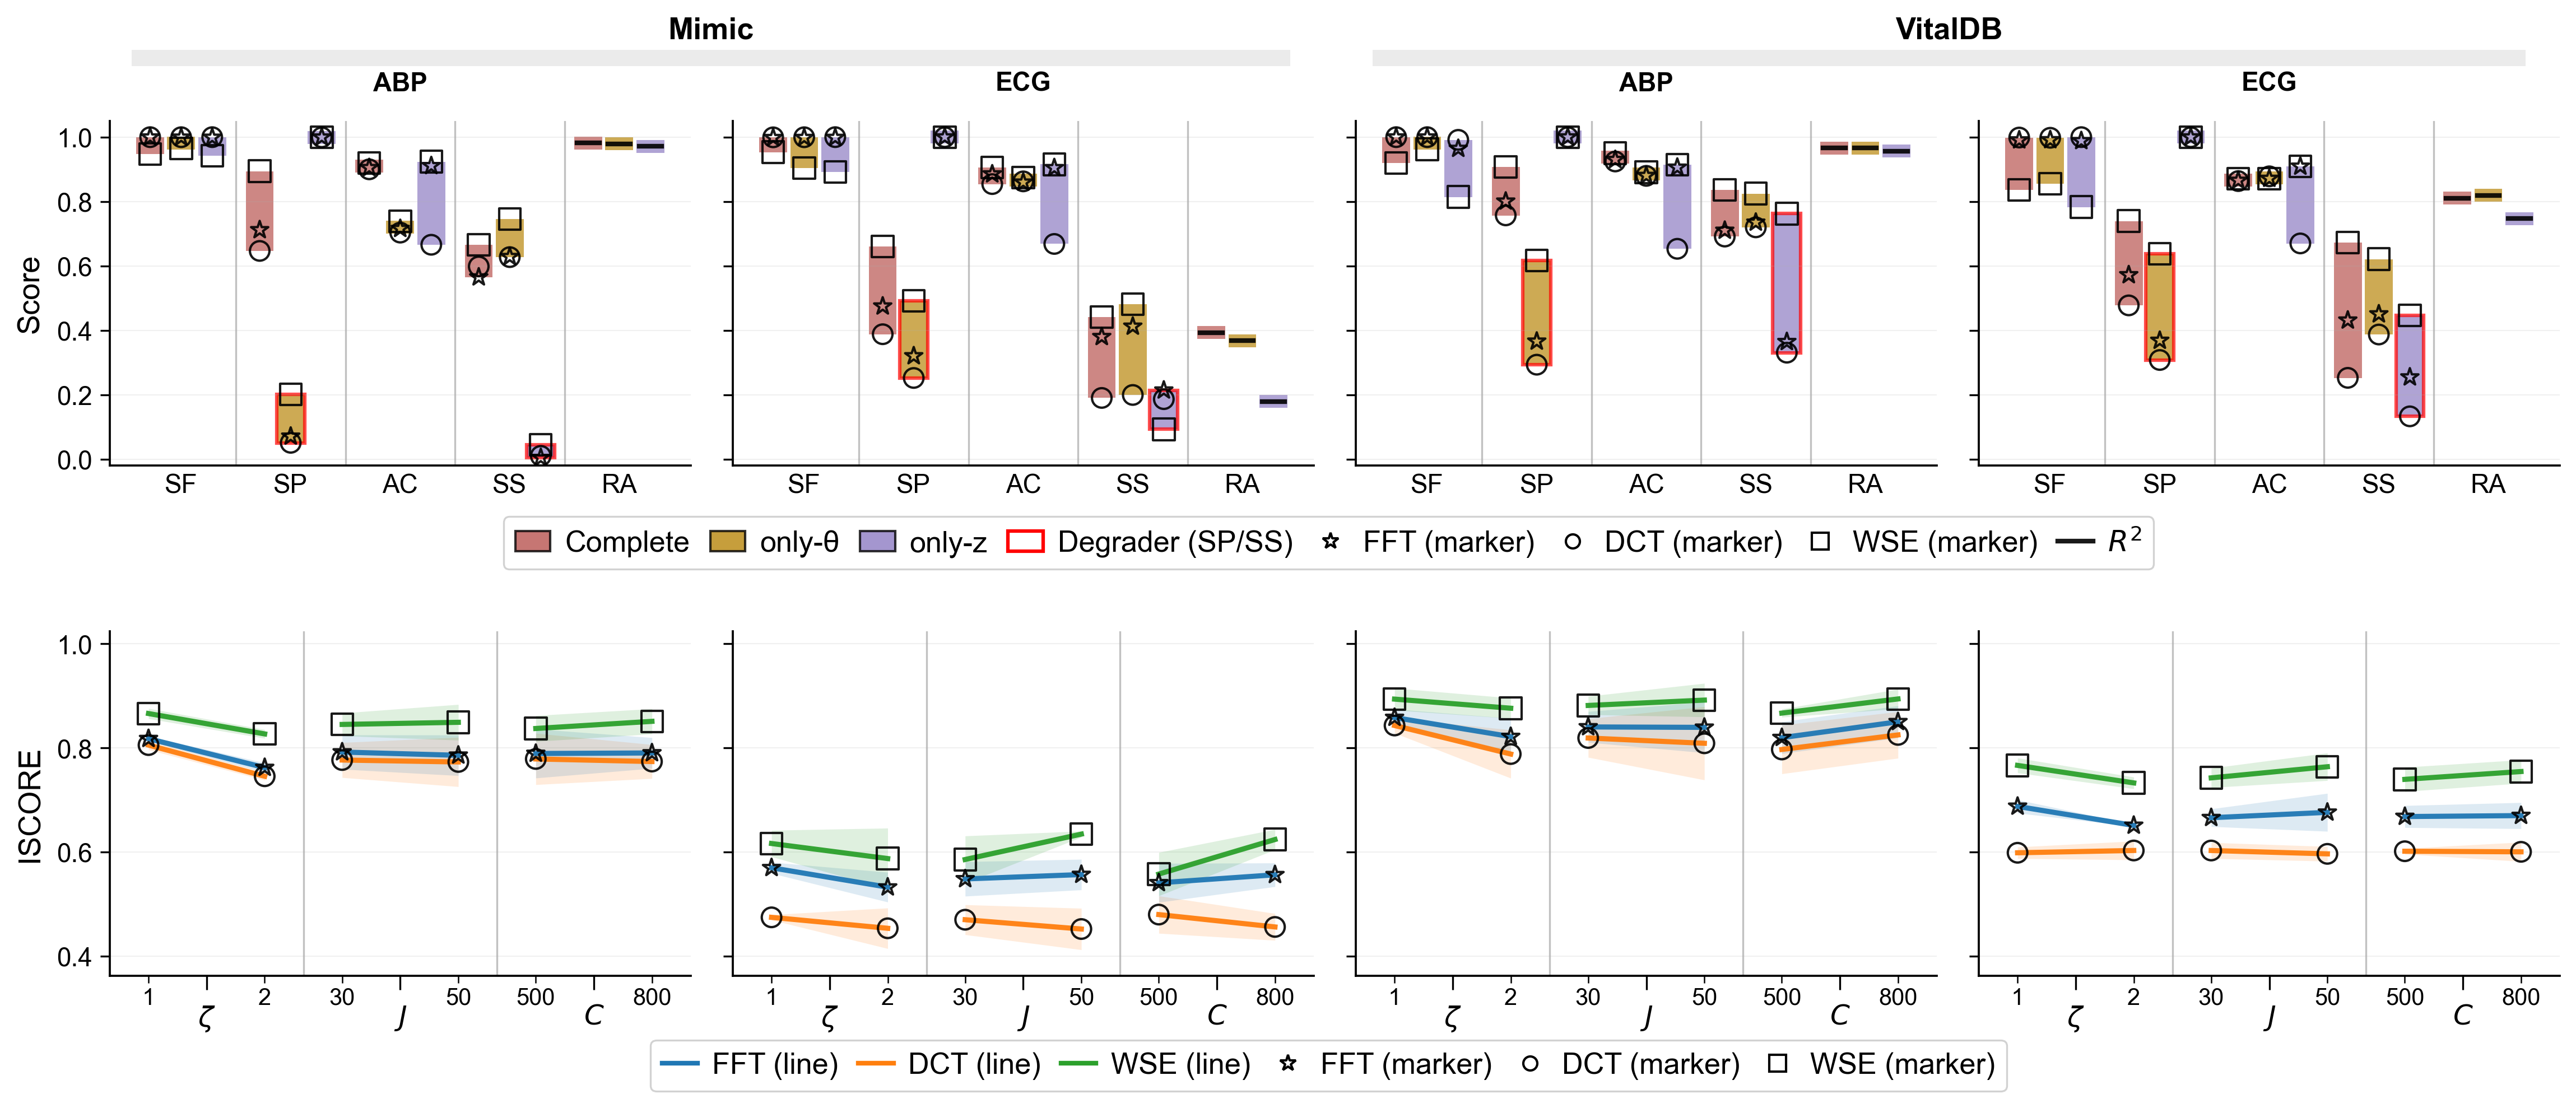

In [14]:
# -*- coding: utf-8 -*-
"""
Performance Range Analysis and Sensitivity Study
2×N grid showing model performance ranges and hyperparameter sensitivity
"""
import os, re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle
from matplotlib.lines import Line2D

# Model configuration
MODEL_ORDER_BOTTOM = ["SKZFC","FC","SKZ"]
COLOR_COMPLETE = "#B85450"
COLOR_FC = "#B8860B"
COLOR_SKZ = "#8E7CC3"
MODEL_COLOR_BOTTOM = {"SKZFC": COLOR_COMPLETE, "FC": COLOR_FC, "SKZ": COLOR_SKZ}

# Color schemes
SENSITIVITY_COLORS = {'$\\zeta$': '#2E8B57', '$J$': '#4682B4', '$C$': '#8B4513'}
METRICTYPE_COLORS_SENS = {'FFT': '#1f77b4','DCT': '#ff7f0e','WSE': '#2ca02c'}

# Visual styling
BOUNDARY_COLOR = '#666666'
BOUNDARY_ALPHA = 0.4
BOUNDARY_LINEWIDTH = 0.8
BOUNDARY_LINESTYLE = '-'
EDGE_LW = 1.0

METRIC_TYPE_MARKERS = {'FFT': '*','DCT': 'o','WSE': 's'}
METRIC_TYPE_MARKER_SIZES = {'*': 60,'o': 70,'s': 85}

mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial","DejaVu Sans"],
    "font.size": 13,
    "axes.titlesize": 15,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 10,
    "axes.linewidth": 0.9,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.facecolor": "white",
    "figure.facecolor": "white",
    "xtick.major.size": 4,
    "ytick.major.size": 4,
    "xtick.major.width": 0.8,
    "ytick.major.width": 0.8,
    "figure.dpi": 300,
})

# Data loading
df_sens = SensitivityDetailTabs.copy()
df_bottom = AblCompTabs.copy()
df_bottom = df_bottom.rename(columns={'MS':'SF', 'MP':'SP'})


# Data preprocessing
metric_name_map = {"fft": "FFT", "matching_pursuit": "DCT", "welch_evo": "WSE"}
METRICS = ["SF","SP","AC","SS","RA"]

def get_base_model_bottom(model_name: str) -> str:
    """Extract base model type from model name"""
    name = str(model_name)
    if re.match(r"^\s*SKZFC\b", name, flags=re.IGNORECASE) or "SKZFC" in name: return "SKZFC"
    if re.match(r"^\s*FC\b", name, flags=re.IGNORECASE) or name.startswith("FC_") or " FC" in name: return "FC"
    if re.match(r"^\s*SKZ\b", name, flags=re.IGNORECASE) or "SKZ" in name: return "SKZ"
    return "OTHER"

# Prepare performance data
df_bottom["BaseModel"] = df_bottom["Model"].apply(get_base_model_bottom)
df_bottom = df_bottom[df_bottom["BaseModel"].isin(MODEL_ORDER_BOTTOM)].copy()
df_bottom["SourceType"] = df_bottom["Source"] + " : " + df_bottom["Type"]
df_bottom['MetricType'] = df_bottom['MetricType'].map(lambda x: metric_name_map.get(x, x))

df_top_temp = df.copy()
df_top_temp['SourceType'] = df_top_temp['Source'] + ' : ' + df_top_temp['Type']
col_labels = sorted(df_top_temp['SourceType'].dropna().unique().tolist())

val_cols = [m for m in METRICS if m in df_bottom.columns]

# Convert to long format for analysis
long_df_bottom = df_bottom.melt(
    id_vars=[c for c in df_bottom.columns if c not in METRICS],
    value_vars=val_cols, var_name="Metric", value_name="Score"
)

# Aggregate performance data by group
performance_data = {}

for (sourcetype, metric, basemodel), group in long_df_bottom.groupby(["SourceType", "Metric", "BaseModel"]):
    if sourcetype not in performance_data:
        performance_data[sourcetype] = {}
    if metric not in performance_data[sourcetype]:
        performance_data[sourcetype][metric] = {}
    
    # Overall range across all MetricTypes
    all_scores = group["Score"].values
    min_score = np.min(all_scores)
    max_score = np.max(all_scores)
    
    # Individual scores per MetricType
    metric_type_scores = {}
    for metrictype, subgroup in group.groupby("MetricType"):
        metric_type_scores[metrictype] = subgroup["Score"].mean()
    
    performance_data[sourcetype][metric][basemodel] = {
        'min': min_score,
        'max': max_score,
        'mean': np.mean(all_scores),
        'metric_type_scores': metric_type_scores
    }

# Sensitivity data preprocessing
df_sens['MetricType'] = df_sens['MetricType'].map(lambda x: metric_name_map.get(x, x))
df_sens['SourceType'] = df_sens['Source'] + ' : ' + df_sens['Type']


# Calculate TotalSum for proper weighted averaging
df_sens['TotalSum'] = df_sens['mean'] * df_sens['n']
df_sens = df_sens[~df_sens['IscoreType'].isin([ 'MS', 'MP', 'AC', 'SS', 'RA'])].copy()

# Fixed aggregation: properly weighted average instead of mean of means
sens_agg = df_sens.groupby(['Source', 'Type', 'Hyperparameter', 'Setting', 'MetricType']).agg({
    'TotalSum': 'sum',    # Sum of all TotalSum values
    'n': 'sum',           # Sum of all sample counts
    'std': 'mean',        # Keep original std averaging
    'max': 'max',         # Keep original max
    'min': 'min'          # Keep original min
}).reset_index()

# Calculate proper weighted mean
sens_agg['mean'] = sens_agg['TotalSum'] / sens_agg['n']

# Clean up temporary column and restore original structure
sens_agg = sens_agg.drop('TotalSum', axis=1)

sens_agg['SourceType'] = sens_agg['Source'] + ' : ' + sens_agg['Type']
sens_agg["SourceType"] = pd.Categorical(sens_agg["SourceType"], categories=col_labels, ordered=True)
sens_agg.sort_values(["SourceType", "Hyperparameter", "Setting", "MetricType"], inplace=True)

# Create figure
n_cols = len(col_labels)
HSPACE = 0.4
LEGEND_ROW1_Y_OFFSET = 0.005
LEGEND_ROW1_X = 0.53
LEGEND_ROW2_Y = 0.0
LEGEND_ROW2_X = 0.53

fig, axes = plt.subplots(2, n_cols, figsize=(16, 6.5), squeeze=False, sharey=False)

for ax in axes.ravel():
    ax.set_facecolor("white")
    ax.grid(axis='y', linestyle='-', linewidth=0.5, alpha=0.18, zorder=0)

# Row 0: Performance comparison
YBUF = 0.08
top_r = 0
x_metrics = np.arange(len(METRICS))
group_width = 0.85
bar_width = group_width / len(MODEL_ORDER_BOTTOM)
offsets_bt = np.linspace(-group_width/2 + bar_width/2, group_width/2 - bar_width/2, len(MODEL_ORDER_BOTTOM))
all_values_top = []

for c, srctype in enumerate(col_labels):
    ax = axes[top_r, c]
    
    if srctype not in performance_data:
        ax.set_visible(False)
        continue

    for k, model in enumerate(MODEL_ORDER_BOTTOM):
        xpos = x_metrics + offsets_bt[k]

        for i, metric in enumerate(METRICS):
            if metric not in performance_data[srctype] or model not in performance_data[srctype][metric]:
                continue
                
            data = performance_data[srctype][metric][model]
            min_val = data['min']
            max_val = data['max']
            metric_type_scores = data['metric_type_scores']
            
            all_values_top.extend([min_val, max_val])

            # Draw performance range
            range_width = bar_width * 0.9
            range_height = max_val - min_val
            min_height = 0.04

            if range_height < min_height:
                display_height = min_height
                center_y = (min_val + max_val) / 2
                display_min = center_y - display_height / 2
            else:
                display_height = range_height
                display_min = min_val

            # Determine if this is the worst model for MP or SS
            edge_color = 'none'
            edge_width = 0
            if metric in ['SP', 'SS']:
                # Find worst performing model for this metric
                model_means = {}
                for m in MODEL_ORDER_BOTTOM:
                    if m in performance_data[srctype][metric]:
                        model_means[m] = performance_data[srctype][metric][m]['mean']
                
                if len(model_means) >= 2:
                    worst_model = min(model_means.keys(), key=lambda x: model_means[x])
                    if model == worst_model:
                        edge_color = 'red'
                        edge_width = 1.5

            rect = Rectangle((xpos[i] - range_width/2, display_min),
                             range_width, display_height,
                             facecolor=MODEL_COLOR_BOTTOM[model], alpha=0.7,
                             edgecolor=edge_color, linewidth=edge_width, zorder=1)
            ax.add_patch(rect)

            # Plot individual MetricType scores
            for metrictype, score in metric_type_scores.items():
                if metric == "RA":
                    # RA values are identical across MetricTypes
                    ax.plot([xpos[i] - range_width*0.4, xpos[i] + range_width*0.4],
                            [score, score],
                            color='black', linewidth=2.0, alpha=0.9, zorder=6)
                    break
                else:
                    marker = METRIC_TYPE_MARKERS.get(metrictype, 'o')
                    marker_size = METRIC_TYPE_MARKER_SIZES.get(marker, 27)
                    ax.scatter(xpos[i], score, marker=marker,
                               facecolor='none', edgecolor='black',
                               s=marker_size, linewidth=1.0, alpha=0.9, zorder=5)

    ax.set_xticks(x_metrics)
    ax.set_xticklabels(METRICS)
    ax.tick_params(axis='x', length=0)
    
    # Add metric boundaries
    for j in range(len(METRICS) - 1):
        ax.axvline(x=x_metrics[j] + 0.5, color=BOUNDARY_COLOR, linestyle=BOUNDARY_LINESTYLE,
                   linewidth=BOUNDARY_LINEWIDTH, alpha=BOUNDARY_ALPHA, zorder=0)
    
    if c == 0: 
        ax.set_ylabel("Score", labelpad=5, fontsize=13)
    else: 
        ax.set_ylabel("")
        ax.tick_params(axis='y', which='both', labelleft=False)
    
    # Clean up titles
    type_only = srctype.split(' : ')[-1] if ' : ' in srctype else srctype
    if type_only == 'ART':
        type_only = 'ABP'
    elif type_only == 'II':
        type_only = 'ECG'
    ax.set_title(type_only, fontsize=11, fontweight='bold', pad=13)

# Row 1: Sensitivity analysis
HYPERPARAMS = ['$\\zeta$', '$J$', '$C$']

def _setting_sort_key(x):
    """Sort settings numerically when possible"""
    sx = str(x)
    if re.fullmatch(r"-?\d+(\.\d+)?", sx):
        return (0, float(sx))
    parts = re.split(r"(\d+)", sx)
    return (1, [int(p) if p.isdigit() else p.lower() for p in parts])

all_values_sens = []

for c, srctype in enumerate(col_labels):
    ax = axes[1, c]
    sub = sens_agg[sens_agg["SourceType"] == srctype]
    if sub.empty:
        ax.set_visible(False)
        continue

    TOTAL_WIDTH = 3.0
    INNER_PAD = 0.2
    segment_boundaries = [i for i in range(len(HYPERPARAMS) + 1)]
    segment_centers = [i + 0.5 for i in range(len(HYPERPARAMS))]
    boundary_positions = segment_boundaries[1:-1]

    x_positions_minor, x_labels_minor = [], []
    hp_index = {h: i for i, h in enumerate(HYPERPARAMS)}

    for hp in HYPERPARAMS:
        i = hp_index[hp]
        segment_left, segment_right = segment_boundaries[i], segment_boundaries[i + 1]
        inner_left, inner_right = segment_left + INNER_PAD, segment_right - INNER_PAD
        sub_hp = sub[sub['Hyperparameter'] == hp]
        if sub_hp.empty: 
            continue

        settings = sorted(sub_hp['Setting'].unique(), key=_setting_sort_key)
        n = len(settings)
        if n <= 1: 
            x_map = {settings[0]: (inner_left + inner_right) / 2}
        else:      
            x_map = {s: x for s, x in zip(settings, np.linspace(inner_left, inner_right, n))}

        for mt in sub_hp['MetricType'].unique():
            sub_hp_mt = sub_hp[sub_hp['MetricType'] == mt].copy()
            sub_hp_mt['x'] = sub_hp_mt['Setting'].map(x_map)
            sub_hp_mt = sub_hp_mt.dropna(subset=['x']).sort_values('x')
            xi = sub_hp_mt['x'].to_numpy(float)
            y = sub_hp_mt['mean'].to_numpy(float)
            s = sub_hp_mt['std'].to_numpy(float)
            if len(xi) == 0: 
                continue

            color = METRICTYPE_COLORS_SENS.get(mt, '#666666')
            marker = METRIC_TYPE_MARKERS.get(mt, 'o')
            marker_size = METRIC_TYPE_MARKER_SIZES.get(marker, 27)

            ax.plot(xi, y, color=color, linewidth=2.2, alpha=0.95, zorder=5)
            ax.scatter(xi, y, marker=marker, facecolor='none', edgecolor='black',
                       s=marker_size, linewidth=1.0, alpha=0.9, zorder=6)
            ax.fill_between(xi, y - s, y + s, alpha=0.15, color=color, linewidth=0, zorder=4)
            all_values_sens.extend((y - s).tolist())
            all_values_sens.extend((y + s).tolist())

        for s in settings:
            x_positions_minor.append(x_map[s])
            x_labels_minor.append(str(s))

    # Add hyperparameter boundaries
    for boundary_x in boundary_positions:
        ax.axvline(x=boundary_x, color=BOUNDARY_COLOR, linestyle=BOUNDARY_LINESTYLE,
                   linewidth=BOUNDARY_LINEWIDTH, alpha=BOUNDARY_ALPHA, zorder=0)

    ax.set_xticks(segment_centers)
    ax.set_xticklabels(HYPERPARAMS, fontsize=12)
    ax.tick_params(axis='x', which='major', length=6, pad=6)
    
    if x_positions_minor:
        ax.set_xticks(x_positions_minor, minor=True)
        ax.set_xticklabels(x_labels_minor, minor=True, fontsize=10)
        ax.tick_params(axis='x', which='minor', length=3, pad=2)
    ax.set_xlim(0, TOTAL_WIDTH)

    if c == 0: 
        ax.set_ylabel("ISCORE", labelpad=5, fontsize=13)
    else: 
        ax.set_ylabel("")
        ax.tick_params(axis='y', which='both', labelleft=False)

# Set y-axis limits
if all_values_top:
    ymin = max(0.0, float(np.nanmin(all_values_top)) - 0.02)
    ymax_raw = float(np.nanmax(all_values_top))
    ymax = 1.05 if ymax_raw >= 0.95 else min(1.05, ymax_raw + YBUF)
    for c in range(n_cols):
        ax = axes[top_r, c]
        if ax.has_data(): 
            ax.set_ylim(ymin-0.02, ymax)

if all_values_sens:
    sens_ymin = max(0.0, float(np.nanmin(all_values_sens)) - 0.05)
    sens_ymax_raw = float(np.nanmax(all_values_sens))
    sens_ymax = 1.05 if sens_ymax_raw >= 0.95 else min(1.05, sens_ymax_raw + 0.1)
    for c in range(n_cols):
        ax = axes[1, c]
        if ax.has_data(): 
            ax.set_ylim(sens_ymin, sens_ymax)

# Add dataset group headers
mimic_cols = [i for i, label in enumerate(col_labels) if 'Mimic' in label]
vitaldb_cols = [i for i, label in enumerate(col_labels) if 'VitalDB' in label]

if mimic_cols and vitaldb_cols:
    pos_start = axes[0, mimic_cols[0]].get_position()
    pos_end = axes[0, mimic_cols[-1]].get_position()
    group1_x0, group1_x1 = pos_start.x0 - 0.04, pos_end.x1 + 0.02
    
    pos_start = axes[0, vitaldb_cols[0]].get_position()
    pos_end = axes[0, vitaldb_cols[-1]].get_position()
    group2_x0, group2_x1 = pos_start.x0 + 0.017, pos_end.x1 + 0.075

    bar_h = 0.015
    top_y = max(ax.get_position().y1 for ax in axes[0, :]) + 0.035
    
    rect1 = Rectangle((group1_x0, top_y), group1_x1 - group1_x0, bar_h,
                      transform=fig.transFigure, facecolor="#cfcfcf", alpha=0.4, zorder=0)
    rect2 = Rectangle((group2_x0, top_y), group2_x1 - group2_x0, bar_h,
                      transform=fig.transFigure, facecolor="#cfcfcf", alpha=0.4, zorder=0)
    fig.patches.extend([rect1, rect2])
    
    fig.text((group1_x0 + group1_x1)/2, top_y + bar_h + 0.005, "Mimic",
             ha='center', va='bottom', fontsize=13, fontweight='bold')
    fig.text((group2_x0 + group2_x1)/2, top_y + bar_h + 0.005, "VitalDB",
             ha='center', va='bottom', fontsize=13, fontweight='bold')

plt.tight_layout(rect=[0.03, 0.0, 1, 0.94], h_pad=HSPACE*11)
fig.canvas.draw()

# Position legends between rows
first_row_bottom = min(ax.get_position().y0 for ax in axes[0, :])
second_row_top = max(ax.get_position().y1 for ax in axes[1, :])
mid_y = (first_row_bottom + second_row_top) / 2

# Create legends
handles_models_row1 = [
    Patch(facecolor=COLOR_COMPLETE, edgecolor='black', alpha=0.8, linewidth=EDGE_LW, label="Complete"),
    Patch(facecolor=COLOR_FC, edgecolor='black', alpha=0.8, linewidth=EDGE_LW, label="only-θ"),
    Patch(facecolor=COLOR_SKZ, edgecolor='black', alpha=0.8, linewidth=EDGE_LW, label="only-z"),
    Patch(facecolor='none', edgecolor='red', alpha=1.0, linewidth=1.5, label="Degrader (SP/SS)"),
]
handles_markers_common = [
    Line2D([0],[0], marker='*', color='w', markerfacecolor='none', markeredgecolor='black',
           markersize=7, markeredgewidth=1.0, linewidth=0, label='FFT (marker)'),
    Line2D([0],[0], marker='o', color='w', markerfacecolor='none', markeredgecolor='black',
           markersize=6, markeredgewidth=1.0, linewidth=0, label='DCT (marker)'),
    Line2D([0],[0], marker='s', color='w', markerfacecolor='none', markeredgecolor='black',
           markersize=7, markeredgewidth=1.0, linewidth=0, label='WSE (marker)'),
]
handle_r2 = [Line2D([0],[0], color='black', linestyle='-', linewidth=2.0, label=r'$R^2$', alpha=0.9)]

handles_mt_lines_row2 = [
    Line2D([0],[0], color=METRICTYPE_COLORS_SENS['FFT'], linewidth=2.0, label='FFT (line)'),
    Line2D([0],[0], color=METRICTYPE_COLORS_SENS['DCT'], linewidth=2.0, label='DCT (line)'),
    Line2D([0],[0], color=METRICTYPE_COLORS_SENS['WSE'], linewidth=2.0, label='WSE (line)'),
]

legend_row1 = fig.legend(
    handles=handles_models_row1 + handles_markers_common + handle_r2,
    loc="center",
    bbox_to_anchor=(LEGEND_ROW1_X, mid_y + LEGEND_ROW1_Y_OFFSET),
    bbox_transform=fig.transFigure,
    ncol=8, frameon=True, borderpad=0.4,
    handlelength=1.2, handletextpad=0.5, columnspacing=0.7, fontsize=12.5,
)
if legend_row1:
    fr = legend_row1.get_frame()
    fr.set_facecolor("white")
    fr.set_edgecolor("#808080")
    fr.set_alpha(0.35)
    fr.set_linewidth(0.8)

legend_row2 = fig.legend(
    handles=handles_mt_lines_row2 + handles_markers_common,
    loc="center",
    bbox_to_anchor=(LEGEND_ROW2_X, LEGEND_ROW2_Y),
    bbox_transform=fig.transFigure,
    ncol=6, frameon=True, borderpad=0.4,
    handlelength=1.2, handletextpad=0.5, columnspacing=0.7, fontsize=12.5,
)
if legend_row2:
    fr2 = legend_row2.get_frame()
    fr2.set_facecolor("white")
    fr2.set_edgecolor("#808080")
    fr2.set_alpha(0.35)
    fr2.set_linewidth(0.8)

# Save figure
SAVE_DIR = './PaperWork/Figures/'
SAVE_NAME = 'Performance_range_analysis_and_sensitivity_study.png'
os.makedirs(SAVE_DIR, exist_ok=True)
outpath = os.path.join(SAVE_DIR, SAVE_NAME)
plt.savefig(outpath, bbox_inches="tight", dpi=300, facecolor='white')
print(f"[Saved] {outpath}")
plt.show()